
### Installing Requirements

#### First, create a virtual environment to keep track of dependencies:
conda create -n geopy3 python=3.7 anaconda <br>

conda activate geopy3

#### Now install GDAL, Rasterio, alongside JupyterLab ::
conda install gdal <br>

conda install -c conda-forge rasterio jupyterlab




### Example 1

### Plotting using Rasterio

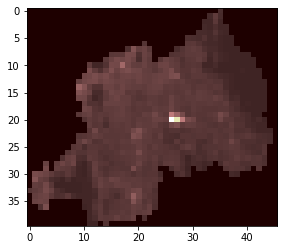

In [1]:
import rasterio
from matplotlib import pyplot
src = rasterio.open("rwa_population.asc")
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

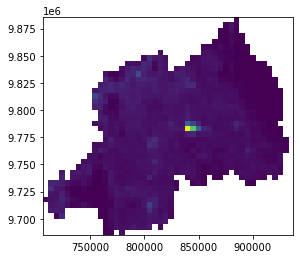

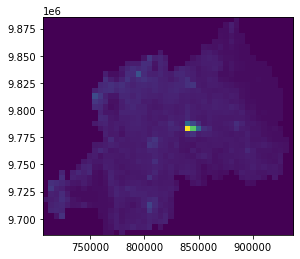

<AxesSubplot:>

In [2]:
from rasterio.plot import show
show(src)
show(src.read(), transform=src.transform)

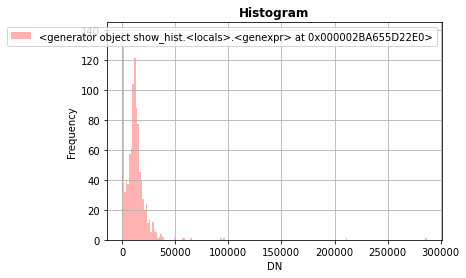

In [3]:
import rasterio
from rasterio.plot import show_hist

src = rasterio.open("rwa_population.asc", skiprows=6)
#myArray  = np.loadtxt("rwa_population.asc", skiprows=6)

show_hist(
    src, bins=184, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")

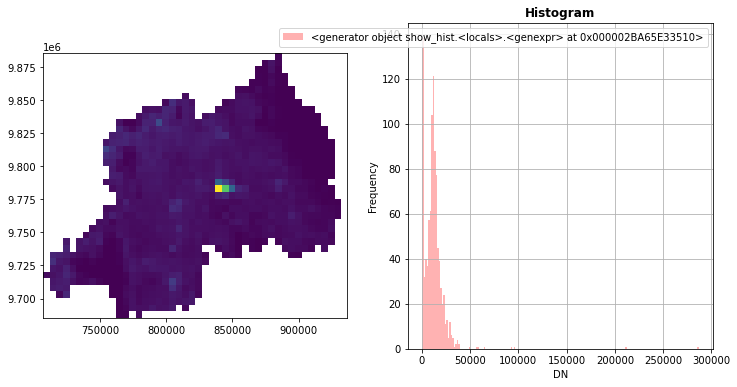

In [4]:
 fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(12,6))
show(src, ax=axrgb)
show_hist(src, bins=184, histtype='stepfilled',lw=0.0, stacked=False, alpha=0.3, ax=axhist)
pyplot.show()

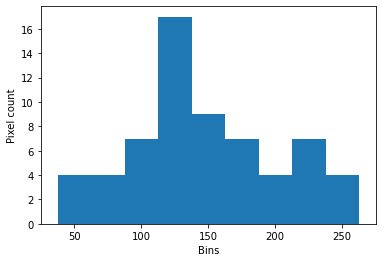

In [5]:
import numpy as np
import matplotlib.pyplot as plt

myArray  = np.loadtxt("rwa_population.asc", skiprows=6)

# Convert raster to numpy array and calculate histogram
hist, bins = np.histogram(myArray, bins = [25,50,75,100,125,150,175,200,225,250,275])

# Plot the histogram
plt.bar(bins[:-1], hist, width = 25)
plt.xlim(min(bins), max(bins))
plt.ylabel('Pixel count')
plt.xlabel('Bins')
plt.show() 

## Example 2
### Scatter Plot the Rasters

#### Define the Raveling Function

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#fetch data cleans and ravels rasters. returns raveled raster
def fetch_data(raster_file,title="", null_value=-9999):
    #fname = raster_file
    #print(fname,0)
    
    #Using PIL to import raster, and convert it to numpy array
    #im = Image.open(fname)
    #j = np.array(im)
    myArray  = np.loadtxt("rwa_population.asc", skiprows=6)
    j=np.array(myArray)
    
    #Data cleansing, remove the null value, in this case it's -9999
    clean = lambda x: np.nan if x == null_value else x
    cleann = np.vectorize(clean)
    z = np.ravel(j) #ravelling to make a x or y axis
    y = cleann(z)
    retval = y[~np.isnan(y)]
    
    #some visualization to describe the data
    plt.figure(figsize=(7,3))
    plt.hist(retval, color='black', bins=32)
    plt.title(title)
    
    #return raveled data
    return retval

#### Ravel the Data

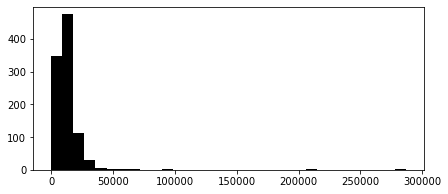

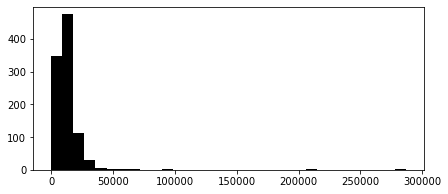

In [7]:
#path to each raster data
x_data_path = "rwa_population.asc"
y_data_path = "rwa_population.asc"
#raveling the data
y_data = fetch_data(y_data_path)
x_data = fetch_data(x_data_path)

#### Plotting the Data

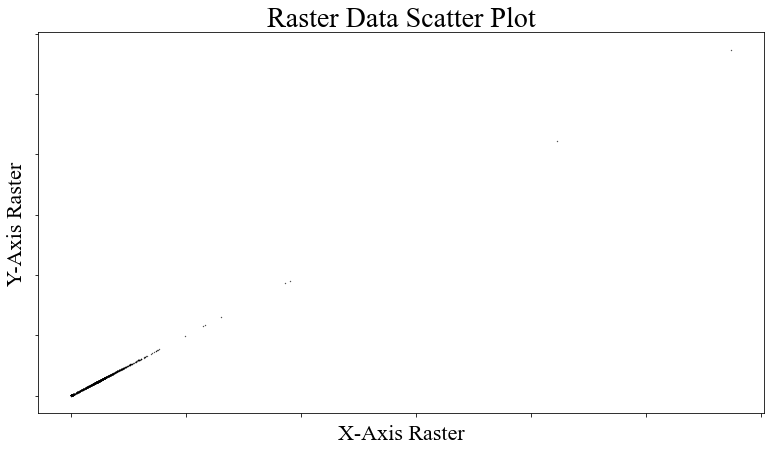

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
#Declaring the figure, and hiding the ticks' labels
fig, ax = plt.subplots(figsize=(13,7))
ax.set_yticklabels([])
ax.set_xticklabels([])
#Actually Plotting the data
plt.scatter(x_data,y_data, s=0.1, c='black')
#Making the graph pretty and informative!
plt.title("Raster Data Scatter Plot", fontsize=28)
plt.xlabel("X-Axis Raster", fontsize=22)
plt.ylabel("Y-Axis Raster", fontsize=22)
plt.show()

### Example 3
### Classifying Raster Using Threshold values

In [9]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Open the ASC file with GDAL


In [10]:
chm_filename = "rwa_population.asc"
chm_dataset = gdal.Open(chm_filename)

#### Read information from Tags


In [11]:
#Display the dataset dimensions, number of bands, driver, and geotransform 
cols = chm_dataset.RasterXSize; print('# of columns:',cols)
rows = chm_dataset.RasterYSize; print('# of rows:',rows)
print('# of bands:',chm_dataset.RasterCount)
print('driver:',chm_dataset.GetDriver().LongName)

# of columns: 46
# of rows: 40
# of bands: 1
driver: Arc/Info ASCII Grid


In [12]:
print('projection:',chm_dataset.GetProjection())


projection: 


##### The geotransform contains information about the origin (upper-left corner) of the raster, the pixel size, and the rotation angle of the data.

In [13]:
print('geotransform:',chm_dataset.GetGeoTransform())


geotransform: (706857.990427, 5000.0, 0.0, 9885274.61987, 0.0, -5000.0)


#### In this case, the geotransform values correspond to:

Left-Most X Coordinate = 706857.990427 <br>
W-E Pixel Resolution = 5000.0 <br>
Rotation (0 if Image is North-Up) = 0.0 <br>
Upper Y Coordinate = 9885274.61987 <br>
Rotation (0 if Image is North-Up) = 0.0 <br>
N-S Pixel Resolution = -5000.0 <br>

#### We can convert this information into a spatial extent (xMin, xMax, yMin, yMax) by combining information about the origin, number of columns & rows, and pixel size

In [14]:
chm_mapinfo = chm_dataset.GetGeoTransform()
xMin = chm_mapinfo[0]
yMax = chm_mapinfo[3]

xMax = xMin + chm_dataset.RasterXSize/chm_mapinfo[1] #divide by pixel width 
yMin = yMax + chm_dataset.RasterYSize/chm_mapinfo[5] #divide by pixel height (note sign +/-)
chm_ext = (xMin,xMax,yMin,yMax)
print('Population raster extent:',chm_ext)

Population raster extent: (706857.990427, 706857.999627, 9885274.61187, 9885274.61987)


#### We can read in a single raster band with GetRasterBand and access information about this raster band such as the No Data Value, Scale Factor, and Statitiscs 

In [15]:
chm_raster = chm_dataset.GetRasterBand(1)
noDataVal = chm_raster.GetNoDataValue(); 
print('no data value:',noDataVal)
scaleFactor = chm_raster.GetScale(); 
if scaleFactor == None:
    #scaleFactor = np.nan
    scaleFactor = 1.0 # can be altered accordingly, in this case as the scalefactor is None, so for calculations it is assigned as 1
#scaleFactor[scaleFactor==int(noDataVal)]=np.nan
print('scale factor:',scaleFactor)
chm_stats = chm_raster.GetStatistics(True,True)
print('Population Statistics: Minimum=%.2f, Maximum=%.2f, Mean=%.3f, StDev=%.3f' % 
      (chm_stats[0], chm_stats[1], chm_stats[2], chm_stats[3]))

no data value: -9999.0
scale factor: 1.0
Population Statistics: Minimum=12.00, Maximum=34529.00, Mean=11399.736, StDev=7669.881


#### Finally, we can convert the raster to an array using the ReadAsArray command. Use the extension astype(np.float) to ensure the array contains floating-point numbers. Once we generate the array, we want to set No Data Values to NaN, and apply the scale factor

In [16]:
chm_array = chm_dataset.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)
#chm_array = chm_dataset.GetRasterBand(1).ReadAsArray(0,0,cols,rows)
chm_array[chm_array==int(noDataVal)]=np.nan #Assign CHM No Data Values to NaN
print (type(chm_array))
print (type(scaleFactor))
chm_array=chm_array/scaleFactor
print('Population Array:\n',chm_array) #display array values

<class 'numpy.ndarray'>
<class 'float'>
Population Array:
 [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


#### To get a better idea of the dataset, print some basic statistics.



In [17]:
# Display statistics (min, max, mean); numpy.nanmin calculates the minimum without the NaN values.
print('Population Statistics:')
print('min:',round(np.nanmin(chm_array),2))
print('max:',round(np.nanmax(chm_array),2))
print('mean:',round(np.nanmean(chm_array),2))

# Calculate the % of pixels that are NaN and non-zero:
pct_nan = np.count_nonzero(np.isnan(chm_array))/(rows*cols)
print('% NaN:',round(pct_nan*100,2))
print('% non-zero:',round(100*np.count_nonzero(chm_array)/(rows*cols),2))


Population Statistics:
min: 12.0
max: 286928.0
mean: 12045.47
% NaN: 46.79
% non-zero: 100.0


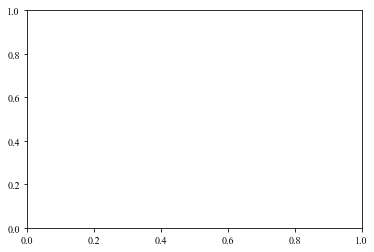

In [18]:
# Define the plot_band_array function from Day 1
def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Spectral'):
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

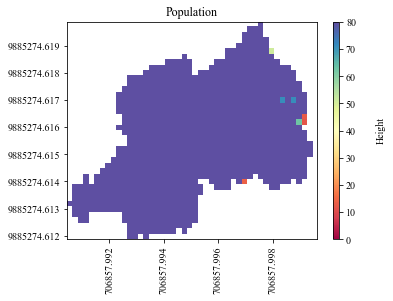

In [19]:
plot_band_array(chm_array,chm_ext,(0,80),title='Population',cmap_title='Height')

#### Plot Histogram of data

Text(0, 0.5, 'Relative Frequency')

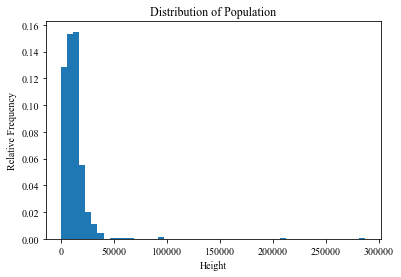

In [20]:
import copy
chm_nonan_array = copy.copy(chm_array)
chm_nonan_array = chm_nonan_array[~np.isnan(chm_array)]
plt.hist(chm_nonan_array,weights=np.zeros_like(chm_nonan_array)+1./
         (chm_array.shape[0]*chm_array.shape[1]),bins=50);
plt.title('Distribution of Population')
plt.xlabel('Height'); plt.ylabel('Relative Frequency')

min: 12.0
max: 286928.0
mean: 12045.47


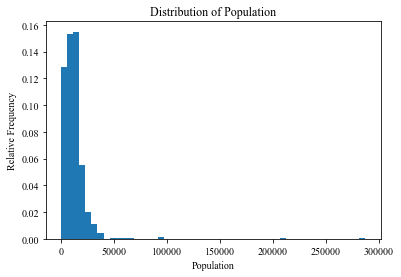

In [21]:
chm_nonzero_array = copy.copy(chm_array)
chm_nonzero_array[chm_array==0]=np.nan
chm_nonzero_nonan_array = chm_nonzero_array[~np.isnan(chm_nonzero_array)]
# Use weighting to plot relative frequency
plt.hist(chm_nonzero_nonan_array,weights=np.zeros_like(chm_nonzero_nonan_array)+1./
         (chm_array.shape[0]*chm_array.shape[1]),bins=50);

# plt.hist(chm_nonzero_nonan_array.flatten(),50) 
plt.title('Distribution of Population')
plt.xlabel('Population'); plt.ylabel('Relative Frequency')
# plt.xlim(0,25); plt.ylim(0,4000000)

print('min:',np.amin(chm_nonzero_nonan_array))
print('max:',round(np.amax(chm_nonzero_nonan_array),2))
print('mean:',round(np.mean(chm_nonzero_nonan_array),2))

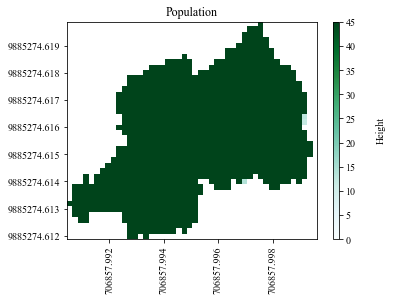

In [22]:
plot_band_array(chm_array,chm_ext,(0,45),title='Population',cmap_title='Height',colormap='BuGn')

### Example 4
#### Loading and Visualizing Raster

In [23]:
import rasterio
import matplotlib.pyplot as plt

raster_path = 'rwa_population.asc'
pop_raster = rasterio.open(raster_path)
pop_raster.shape

(40, 46)

In [24]:
def plot_raster(arr, title=None, figsize=(30,10)):
    """ helper function to plot a raster array """
    fig, ax = plt.subplots(figsize=figsize)
    plt.imshow(arr)
    plt.colorbar()
    plt.title(f'{title}')
    plt.xlabel('Column #')
    plt.ylabel('Row #')
    return fig, ax

(<Figure size 2160x720 with 2 Axes>,
 <AxesSubplot:title={'center':'11792519'}, xlabel='Column #', ylabel='Row #'>)

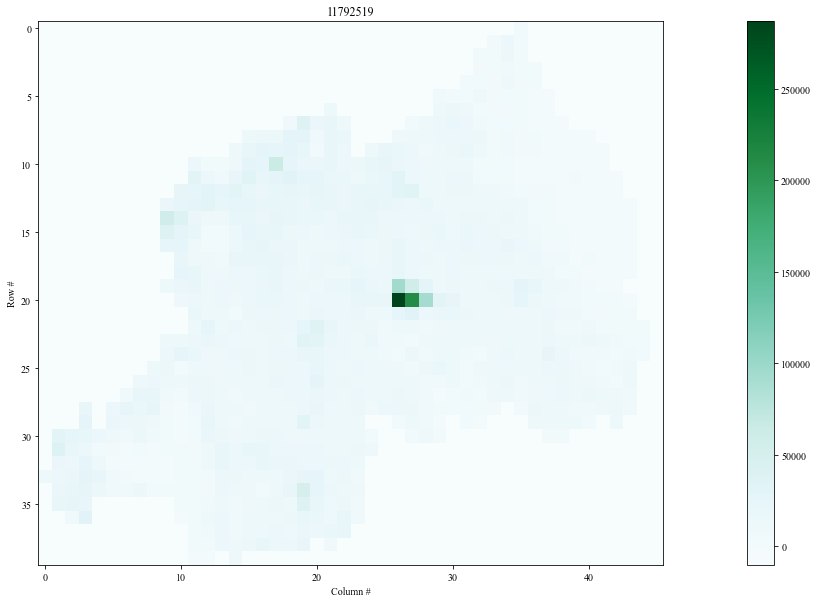

In [25]:
pop_data = pop_raster.read(1)
pop_count = pop_data[pop_data>0].sum()
plot_raster(pop_data, title=pop_count)

#### Raster Sampling 

(<Figure size 2160x720 with 2 Axes>,
 <AxesSubplot:title={'center':'None'}, xlabel='Column #', ylabel='Row #'>)

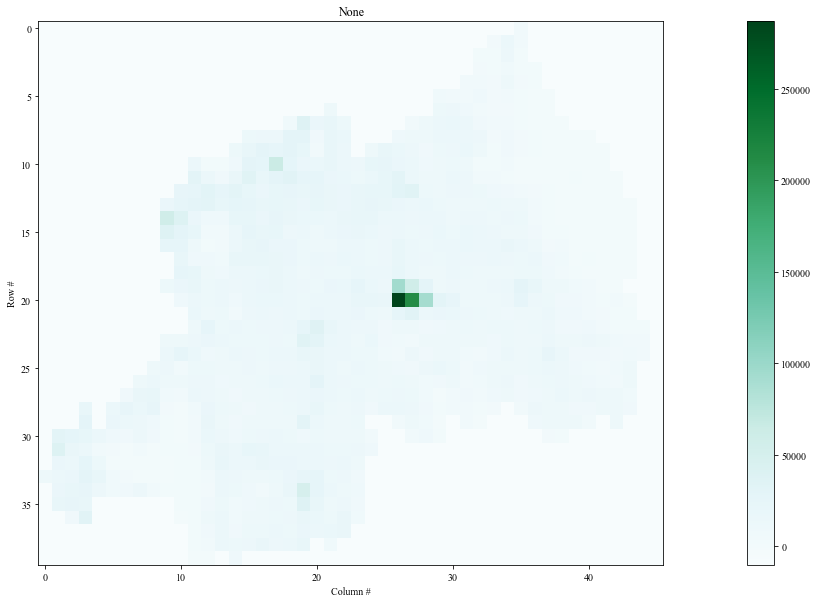

In [26]:
from rasterio.windows import Window

w = pop_raster.read(1, window=Window(0, 0, 512, 256))
plot_raster(w)